### ME 574 Winter 2019 Homework 3 Solution

In [1]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# %env NUMBA_ENABLE_CUDASIM = 1

env: NUMBA_ENABLE_CUDASIM=1


**1) Consider serial evaluation of the integral $I = \int_{0}^{1} \frac{dx}{x^2 + 1}$.**

**a) Determine the exact value of the integral.**

Let $x = tan(u)$, then
$$
dx = \frac{dtan(u)}{du}du = \frac{cos^2(u)+sin^2(u)}{cos^2(u)}du = \frac{1}{cos^2(u)}du
$$

\begin{align}
I &= \int_{0}^{1} \frac{dx}{x^2 + 1} \\
&= \int_{x=0}^{x=1} \frac{1}{tan^2(u) + 1} \frac{1}{cos^2(u)}du \\
&= \int_{x=0}^{x=1} du \\
&= \int_{x=0}^{x=1} darctan(x) \\
&= arctan(1) - arctan(0) \\
&= \frac\pi4
\end{align}

**b) Create a serial implementation of the trapezoidal rule and use it to compute numerical values for $I$ based on a uniformly sampled grid of function values with spacing $h = 10^{-n} \textrm{for} \, n \in {[1,2,3]}$. Present a log-log plot of error vs $h$ and, based on your plotted data, provide a numerical value for the order of convergence of the trapezoidal rule.**

In [10]:
errors = []
m = 10**np.arange(1, 4)
h = 1 / m
for i in range(3):
    x = np.linspace(0, 1, m[i]+1)
    fx = 1 / (x**2+1)
    integral = 0
    for j in range(m[i]):
        integral += (fx[j]+fx[j+1])
    integral *= h[i]/2
    errors.append(np.abs(integral - np.pi/4))

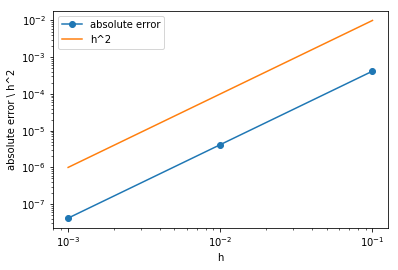

In [11]:
plt.plot(h, errors, 'o-', label='absolute error')
plt.plot(h, np.power(h, 2), label='h^2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('absolute error \ h^2')
plt.legend()

In [12]:
errors

[0.00041666617065860834, 4.1666666663608964e-06, 4.166666667249075e-08]

In [5]:
# log_errors = np.log(errors)
# log_h = np.log(h)
# print((log_errors[2]-log_errors[0])/(log_h[2]-log_h[0]))

From the plot we can see the order of convergence is about $\mathcal O(h^2)$.

**c) Repeat part b using Simpson's rule instead of the trapezoidal rule.**

In [26]:
errors = []
m = 10**np.arange(1, 4)
h = 1 / m
for i in range(len(m)):
    x = np.linspace(0, 1, m[i]+1)
    fx = 1 / (x**2+1)
    integral = 0
    for j in range(0, m[i], 2):
        integral += (fx[j]+4*fx[j+1]+fx[j+2])
    integral *= h[i]/3
    errors.append(np.abs(integral - np.pi/4))

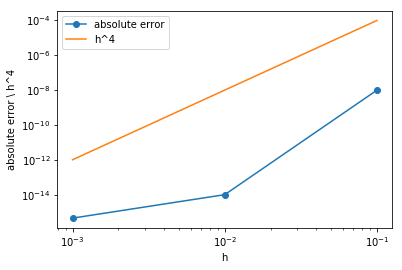

In [36]:
plt.plot(h, errors, 'o-', label='absolute error')
plt.plot(h, np.power(h, 4), label='h^4')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('absolute error \ h^4')
plt.legend()

In [37]:
errors

[9.912644483023314e-09, 9.880984919163893e-15, 4.440892098500626e-16]

We know that simpson's rule should be a fourth order method, yet from the plot we can see the line of absolute error is not a perfect linear line. We print the computed errors and find that the last 2 points' errors are very close to machine $\epsilon$, so we think this may cause deviation of the errors.

**2) Consider parallel evaluation of the same integral $I$ from Problem 1.**

**a) Parallelize your implementation of Simpson's rule as follows:**

Use a kernel function to compute the required array of function values in parallel.

Use another kernel function to compute an array of stencil contributions.

Use a numba reduction to sum the stencil contributions to provide the numerical value of the integral.

In [38]:
@cuda.jit(device=True)
def d_f(x):
    return 1 / (x**2+1)

In [39]:
@cuda.jit
def d_f_eval(d_in, d_out):
    i = cuda.grid(1)
    n = d_in.size
    if i < n:
        d_out[i] = d_f(d_in[i])

In [40]:
@cuda.jit
def k_stencil(d_fx, d_out, h):
    i = cuda.grid(1)
    n = d_out.size
    if i < n:
        idx = 2 * i
        d_out[i] = (d_fx[idx]+4*d_fx[idx+1]+d_fx[idx+2]) * h / 3

In [41]:
@cuda.reduce
def sum_reduce(a, b):
    return a + b

**b) Use the parallel implementation to make another version of your plot from part 1c with $n \in {[2,4,6,8]}$. Discuss your plot and explain salient features.**

In [42]:
para_errors = []
TPB = 1024
m = 10**np.arange(2, 7, 2)
h = 1 / m
for i in range(len(m)):
    N = m[i]+1
    x = np.linspace(0, 1, N, dtype=np.float)
    d_x = cuda.to_device(x)
    d_fx = cuda.device_array_like(x)
    BPG_fx = (N-1)//TPB + 1
    d_f_eval[TPB, BPG_fx](d_x, d_fx)
#     para_fx = d_fx.copy_to_host()
    d_s = cuda.device_array((m[i]//2,), dtype=np.float)
    BPG_s = (d_s.size-1)//TPB + 1
    k_stencil[TPB, BPG_s](d_fx, d_s, h[i])
    s = d_s.copy_to_host()
    integral = sum_reduce(s)
    para_errors.append(np.abs(integral - np.pi/4))
print(para_errors)

[9.880984919163893e-15, 0.0, 1.1102230246251565e-16]


Text(0, 0.5, 'absolute error')

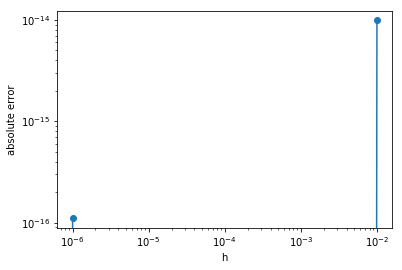

In [44]:
plt.plot(h, para_errors, '-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('absolute error')

In [45]:
para_errors

[9.880984919163893e-15, 0.0, 1.1102230246251565e-16]

As the compute capability of our card (NVIDIA MX150) is limited, we cannot compute in parallel the $n = 8$ case, where the number of threads are too many. So we compute and plot the $n = [2, 4, 6]$ cases.

The plot is weird so we also print out the computed errors. we see that all three cases give errors that are very close to machine $\epsilon$. So we think that in the cases $n \ge 2$ the stepsizes are too small that the machine error gets prominent and results in similar errors.

**3) Consider the initial value problem (IVP) defined by the  differential equation $y'(t) = -10 y(t)$ with intial condition $y(0)=1$.**

**a) Implement the Explicit Euler method and use it to compute and plot numerical solutions of the IVP on $0 \leq t \leq 4$ with stepsize $h = 1,  .1, .01, .001$ . Briefly discuss salient features of your plots. How small must the stepsize be to prevent oscillatory artifacts (i.e. instability) from arising?**

In [47]:
def ee_iter(y0, h):
    return y0 + (-10)*y0*h

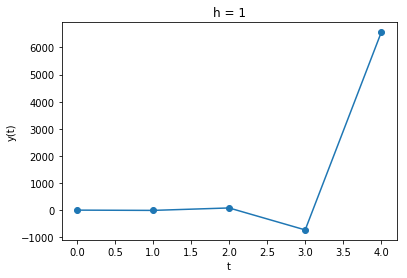

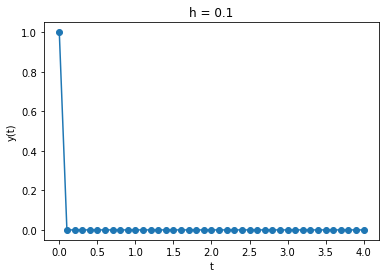

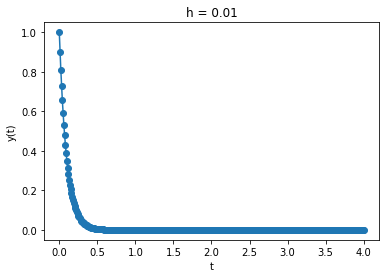

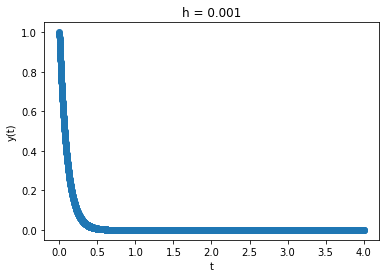

In [48]:
h = [1, .1, .01, .001]
y0 = 1
for i in range(4):
    num_iter = int(4 / h[i])
    t = np.linspace(0, 4, num_iter+1)
    y = np.empty(t.shape)
    y[0] = y0
    for j in range(num_iter):
        y[j+1] = ee_iter(y[j], h[i])
    plt.plot(t, y, '-o')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title(f'h = {h[i]}')
    plt.show()

We see that when $h = 1$, the system is unstable and blows up in the end. When $h = 0.1$, the system becomes stable but converge to equilibrium instantly. For smaller $h$, the system shows a nice asymptotical stability and converge to equilibrium gradually.

From the plots we infer that to prevent instability we must have $h \le 0.1$. This is actually consistent with analytic solution. The forward Euler discrete time system is $y_{n+1} = (1-10h)y_n$. From the stability condition of discrete time linear system
$$
\frac1{(1-10h)} \le 1 \Rightarrow h \le 0.1
$$

**b) Compute and plot the "global" error in your numerical solutions, and produce a plot/fit to determine the order of the method.**

The analytic solution is $y(t) = e^{-10t}$.

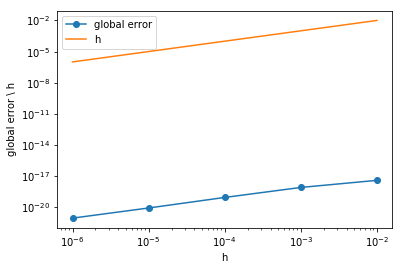

In [49]:
h = 10.**(-np.arange(2, 7))
y0 = 1
g_errors = []
for i in range(len(h)):
    num_iter = int(4 / h[i])
    t = np.linspace(0, 4, num_iter+1)
    y = np.empty(t.shape)
    y[0] = y0
    for j in range(num_iter):
        y[j+1] = ee_iter(y[j], h[i])
    g_errors.append(np.abs(y[-1] - np.exp(-40)))
plt.plot(h, g_errors, '-o', label='global error')
plt.plot(h, h, label='h')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('global error \ h')
plt.legend()

From the plot we can see the order of convergence is about $\mathcal O(h)$.

**c) Consider a simple "predictor-corrector" approach as follows: Compute each step in the solution by computing a "predicted value" using forward Euler and then computing a "corrected" value using the implicit Euler method (plugging in the prediction as the value of $y_{n+1}$ in the backward Euler formula). Implement the predictor-corrector scheme, compute the global error for several stepsizes, and determine the order of the method.**

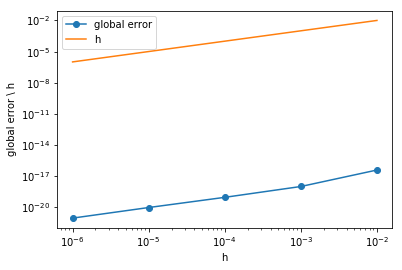

In [50]:
h = 10.**(-np.arange(2, 7))
y0 = 1
g_errors = []
for i in range(len(h)):
    num_iter = int(4 / h[i])
    t = np.linspace(0, 4, num_iter+1)
    y = np.empty(t.shape)
    y[0] = y0
    for j in range(num_iter):
        y1 = ee_iter(y[j], h[i])
        y[j+1] = y[j] + (-10)*y1*h[i]
    g_errors.append(np.abs(y[-1] - np.exp(-40)))
plt.plot(h, g_errors, '-o', label='global error')
plt.plot(h, h, label='h')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('global error \ h')
plt.legend()

From the plot we can see the order of convergence is about $\mathcal O(h)$.